In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output
print(check_output(["ls", "C:/Users/Vaidy/Desktop/Coin_Classification/Coin.tar.gz"]).decode("utf8"))

classification_dataset.tar.gz
regression_dataset.tar.gz
regression_sample



In [2]:
import os
import shutil
import random
import cv2
import matplotlib.pyplot as plt
import scipy.stats
import tensorflow as tf

from keras import applications, optimizers, Input
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization

%matplotlib inline

Using TensorFlow backend.


### Extract images and labels from images in tar.gz file

In [3]:
import tarfile

image_list = []
label_list = []

tar = tarfile.open('classification_dataset.tar.gz', "r:gz")
for tarinfo in tar:
    tar.extract(tarinfo.name)
    if(tarinfo.name[-4:] == '.jpg'):
        image_list.append(np.array(cv2.imread(tarinfo.name, cv2.IMREAD_COLOR)))
        label_list.append(tarinfo.name.split('_')[0])
    if(tarinfo.isdir()):
        os.rmdir(tarinfo.name)
    else:
        os.remove(tarinfo.name)    
   
tar.close()

images = np.array(image_list)
labels = np.array(label_list)

In [4]:
def extract_coins(img, to_size=100):
    # Convert to b&w
    cimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find circles on the image
    circles = cv2.HoughCircles(
        cimg, cv2.HOUGH_GRADIENT, 2, 60, param1=300, param2=30, minRadius=30, maxRadius=50)
    
    # Convert to HSV colorspace
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Define color range for masking
    lower = np.array([0,0,0])
    upper = np.array([255,255,90])
    # Apply the mask
    mask = cv2.blur(cv2.inRange(hsv, lower, upper), (8, 8))
    
    frames = []
    radiuses = []
    # If circles were not found
    if circles is None:
        return None, None
    
    for circle in circles[0]:
        
        center_x = int(circle[0])
        center_y = int(circle[1])
        
        # If center of coin lays in masked coin range
        if not mask[center_y, center_x]:
            continue
        
        # increase radius by C
        # circle detector tends to decrease radius
        radius = circle[2] + 3
        
        radiuses.append(radius)
        
        # Coordinates of upper left corner of square
        x = int(center_x - radius)
        y = int(center_y - radius)
        
        # As radius was increased the coordinates
        # could go out of bounds
        if y < 0:
            y = 0
        if x < 0:
            x = 0
        
        # Scale coins to the same size
        resized = cv2.resize(img[y: int(y + 2 * radius), x: int(x + 2 * radius)], 
                             (to_size, to_size), 
                             interpolation = cv2.INTER_CUBIC)

        frames.append(resized)

    return np.array(frames), radiuses

### Extract the coins images

In [5]:
# The coins images are extracted from original images using extract_coins function
scaled = []
scaled_labels = []
for nominal, image in zip(labels, images):
    #print(image)
    prepared, _ = extract_coins(image)
    if prepared is not None and len(prepared):
        scaled.append(prepared[0])
        scaled_labels.append(nominal)

### Convert string labels to categorical for use in model training

In [6]:
# Convert the string labels to int
print(np.array(scaled_labels).shape)
print(set(scaled_labels))
label_classes = set(scaled_labels)

labels_dict = {}
for v_i, v in enumerate(label_classes):
    labels_dict[v] = v_i
        
print(labels_dict)

labels = []
for label in scaled_labels:
    labels.append(labels_dict[label])
    
print(set(labels))    

y_binary = to_categorical(labels)

print(y_binary)

(3035,)
{'all/100', 'all/10', 'all/25', 'all/5', 'all/50'}
{'all/100': 0, 'all/10': 1, 'all/25': 2, 'all/5': 3, 'all/50': 4}
{0, 1, 2, 3, 4}
[[ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 ..., 
 [ 0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]]


### Show image samples

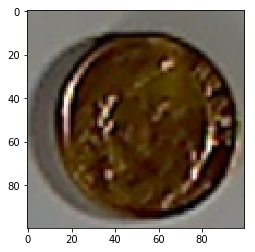

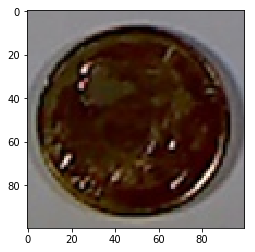

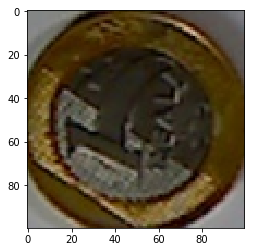

In [7]:
# Plot sample images from list
for image_item in random.sample(scaled, 3): 
    image = np.array(image_item)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

### Model

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(100, 100, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu')) 
model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(data_format="channels_last", pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.75))          # 0.5
model.add(Dense(5))               # 5 is the number of classes
model.add(Activation('softmax'))

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',              # adadelta
    metrics=['accuracy']
)

### Train!

In [9]:
model.fit(
    x=np.array(scaled),
    y=y_binary,
    epochs=10,
    validation_split=0.15,
    batch_size=500,
    verbose=1                  # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
)

Train on 2579 samples, validate on 456 samples
Epoch 1/10
2579/2579 [==============================] - 61s - loss: 2.0907 - acc: 0.3377 - val_loss: 8.0351 - val_acc: 0.2303
Epoch 2/10
2579/2579 [==============================] - 53s - loss: 1.0846 - acc: 0.6212 - val_loss: 7.2255 - val_acc: 0.3421
Epoch 3/10
2579/2579 [==============================] - 52s - loss: 0.8384 - acc: 0.7045 - val_loss: 3.8285 - val_acc: 0.5132
Epoch 4/10
2579/2579 [==============================] - 51s - loss: 0.7202 - acc: 0.7313 - val_loss: 2.9146 - val_acc: 0.5307
Epoch 5/10
2579/2579 [==============================] - 50s - loss: 0.6675 - acc: 0.7534 - val_loss: 2.3185 - val_acc: 0.5066
Epoch 6/10
2579/2579 [==============================] - 51s - loss: 0.6095 - acc: 0.7774 - val_loss: 1.7887 - val_acc: 0.5833
Epoch 7/10
2579/2579 [==============================] - 52s - loss: 0.5617 - acc: 0.8088 - val_loss: 1.8386 - val_acc: 0.5636
Epoch 8/10
2579/2579 [==============================] - 52s - loss: 0.5

### Making predictions

all/10 49%


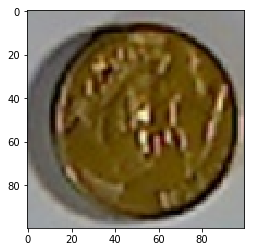

In [10]:
image_list = random.sample(scaled, 1)
prediction = model.predict(np.array(image_list))[0]
#print(labels_dict)
#print(prediction)
#print(np.argmax(prediction))
print(
    list(labels_dict.keys())[list(labels_dict.values()).index(np.argmax(prediction))], 
    "{0:.0f}%".format(np.max(prediction) * 100)
)
plt.imshow(cv2.cvtColor(np.array(image_list)[0], cv2.COLOR_BGR2RGB))
plt.show()
    